<a href="https://colab.research.google.com/github/AI-Junction/Diabetic-Retinopathy/blob/master/DiabeticRetinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check memory allocation to this sesssion

In [2]:
!pip install kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
#filename = "/.kaggle/kaggle.json"
filename = "kaggle.json"
#os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!ls -lha kaggle.json



---x-wx--T 1 root root 65 Jan 27 08:02 kaggle.json


In [3]:
os.path.isdir("/root/.kaggle")

False

In [4]:
dir_kaggle = "/root/.kaggle"
if not os.path.isdir(dir_kaggle):
  !mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/
os.path.isdir(dir_kaggle)

True

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

Create training and test data in this allocated session of colaboratory

In [0]:
!mkdir '/content/Diabetic-Retinopathy'

In [7]:
!kaggle competitions files -c diabetic-retinopathy-detection

name                      size  creationDate         
------------------------  ----  -------------------  
trainLabels.csv.zip       69KB  2015-02-12 19:35:00  
sampleSubmission.csv.zip  82KB  2015-02-12 19:35:00  
sample.zip                10MB  2015-02-12 19:35:03  
train.zip.004              8GB  2015-02-12 20:43:34  
train.zip.002              8GB  2015-02-12 20:49:26  
train.zip.001              8GB  2015-02-12 20:52:47  
train.zip.005              1GB  2015-02-12 20:53:50  
train.zip.003              8GB  2015-02-12 21:39:51  
test.zip.004               8GB  2015-02-13 00:09:14  
test.zip.005               8GB  2015-02-13 00:13:21  
test.zip.002               8GB  2015-02-13 00:19:26  
test.zip.003               8GB  2015-02-13 01:22:17  
test.zip.001               8GB  2015-02-13 01:33:39  
test.zip.006               8GB  2015-02-13 01:39:08  
test.zip.007               3GB  2015-02-13 01:43:54  


In [8]:
if not os.path.isdir("/content/Diabetic-Retinopathy/train"):
  !mkdir "/content/Diabetic-Retinopathy/train"
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.001 -p "/content/Diabetic-Retinopathy/train"


100% 7.81G/7.81G [02:40<00:00, 58.1MB/s]
100% 7.81G/7.81G [02:40<00:00, 52.3MB/s]


In [0]:
if not os.path.isfile("/content/Diabetic-Retinopathy/train/train.zip.001"):
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.001 -p "/content/Diabetic-Retinopathy/train"
  

if not os.path.isfile("/content/Diabetic-Retinopathy/train/train.zip.002"):
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.002 -p "/content/Diabetic-Retinopathy/train"

if not os.path.isfile("/content/Diabetic-Retinopathy/train/train.zip.003"):
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.003 -p "/content/Diabetic-Retinopathy/train"

if not os.path.isfile("/content/Diabetic-Retinopathy/train/train.zip.004"):
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.004 -p "/content/Diabetic-Retinopathy/train"

if not os.path.isfile("/content/Diabetic-Retinopathy/train/train.zip.005"):
  !kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.005 -p "/content/Diabetic-Retinopathy/train"
  

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip -p "/content/Diabetic-Retinopathy/"

In [0]:
!unzip "/content/Diabetic-Retinopathy/trainLabels.csv.zip" -d "/content/Diabetic-Retinopathy/"

In [0]:
!cat /content/Diabetic-Retinopathy/train/train.zip.* >train.zip
#!unzip train.zip

In [14]:
!unzip '/content/train.zip' -d '/content/Diabetic-Retinopathy/train'

Archive:  /content/train.zip
replace /content/Diabetic-Retinopathy/train/train/10003_left.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Diabetic-Retinopathy/train/train/10003_right.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import glob
tot_files = glob.glob('/content/Diabetic-Retinopathy/train/train/*')

In [16]:
print(len(tot_files))

35126


In [0]:
import os
import gzip
import json

import PIL

import numpy as np
import pandas as pd
import skimage
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 1000)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from IPython.core.display import display, HTML, Image
from subprocess import check_output

In [0]:
df = pd.read_csv('/content/Diabetic-Retinopathy/trainLabels.csv')

In [5]:
print(df.shape)

(35126, 2)


In [0]:
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255

In [0]:
def trim(im):
    """trim black margin, http://stackoverflow.com/questions/10615901/trim-whitespace-using-pil"""
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [0]:
def calc_thumbnail_size(img):
    """calculate thumbnail size with constant aspect ratio"""
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
#     print(size)
    return size

In [0]:
def calc_crop_coords(img):
    """crop to square of desired dimension size"""
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)

In [0]:
def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img

In [11]:
df.level.value_counts().to_frame(name='count').T

0     2     1    3    4
count  25810  5292  2443  873  708

In [0]:
df = df.query('image in {0}'.format([_.replace('.jpeg', '') for _ in os.listdir('/content/Diabetic-Retinopathy/train/train')]))

In [13]:
df.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [0]:
data_dir = '/content/Diabetic-Retinopathy/train/train'

In [15]:
PIL.__version__

'4.0.0'

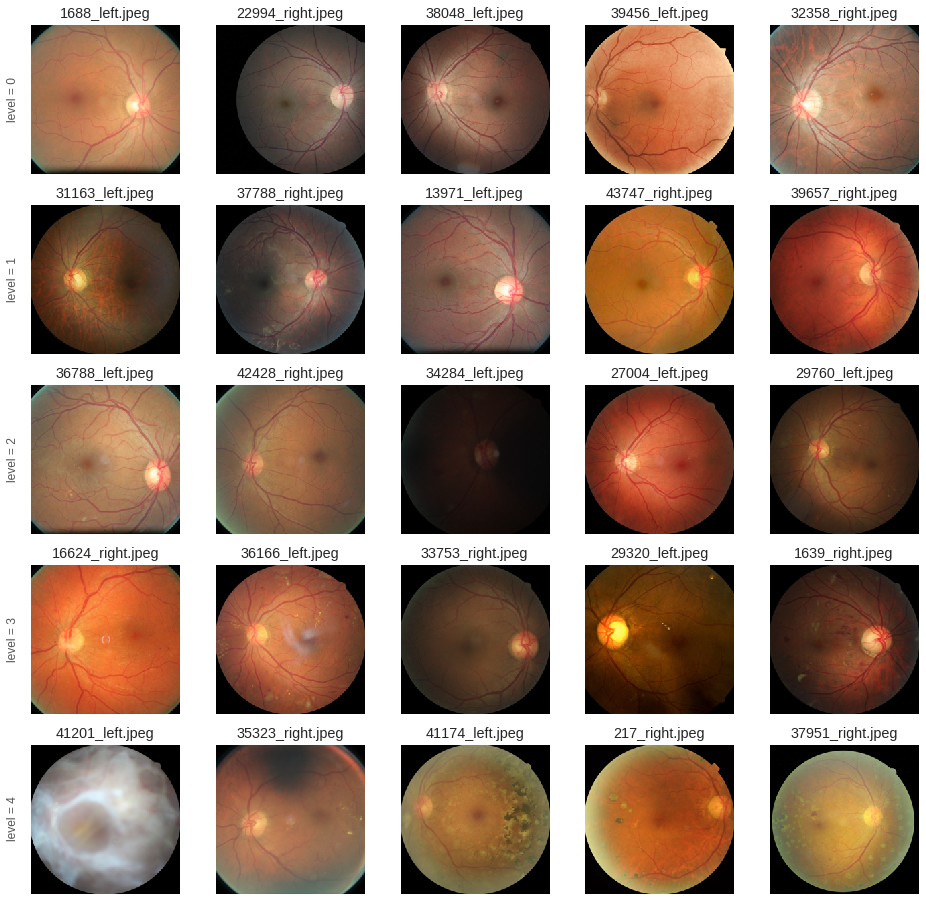

In [16]:
imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(data_dir, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

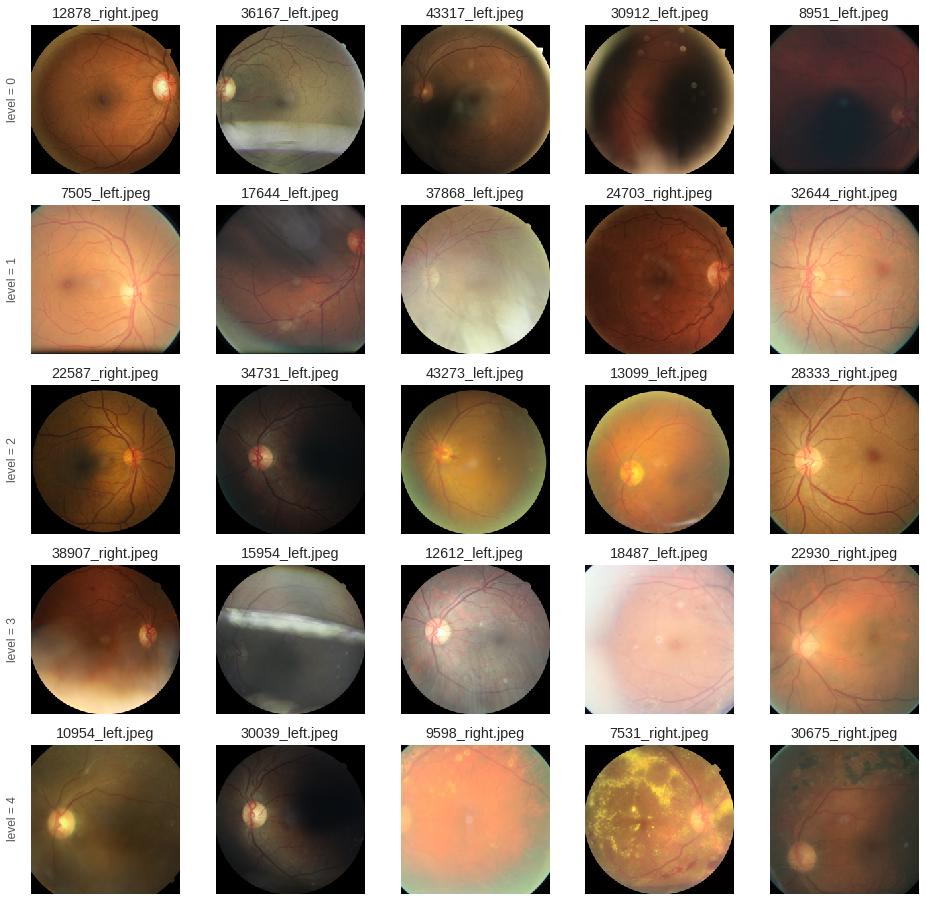

In [17]:
imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(data_dir, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

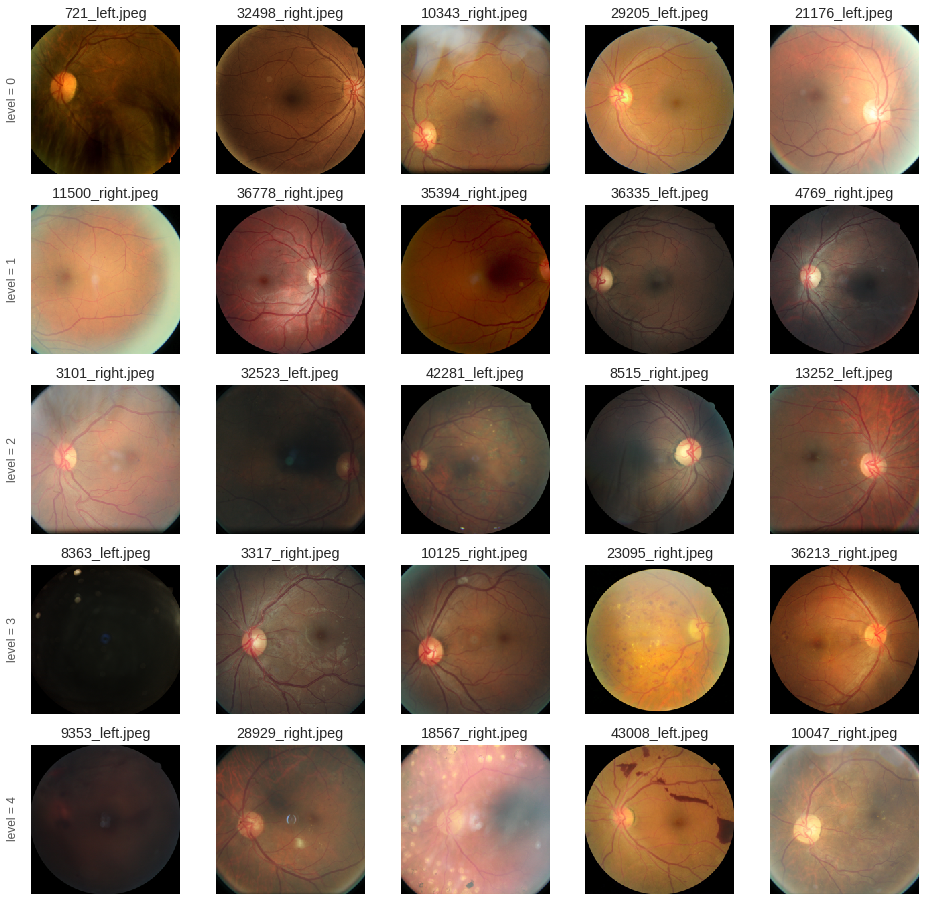

In [18]:
imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(data_dir, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

In [19]:
base_image_dir = os.path.join('/content', 'Diabetic-Retinopathy', 'train', 'train')
retina_df = pd.read_csv('/content/Diabetic-Retinopathy/trainLabels.csv')
print(retina_df.shape)
print(base_image_dir)
print(retina_df['image'][:5])
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

(35126, 2)
/content/Diabetic-Retinopathy/train/train
0     10_left
1    10_right
2     13_left
3    13_right
4     15_left
Name: image, dtype: object
35126 images found of 35126 total


Using TensorFlow backend.


image  level PatientId  \
9898    12476_left      0     12476   
21727  27369_right      0     27369   
9022    11314_left      0     11314   

                                                    path  exists  eye  \
9898   /content/Diabetic-Retinopathy/train/train/1247...    True    1   
21727  /content/Diabetic-Retinopathy/train/train/2736...    True    0   
9022   /content/Diabetic-Retinopathy/train/train/1131...    True    1   

                       level_cat  
9898   [1.0, 0.0, 0.0, 0.0, 0.0]  
21727  [1.0, 0.0, 0.0, 0.0, 0.0]  
9022   [1.0, 0.0, 0.0, 0.0, 0.0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbc11450f0>,
      dtype=object)

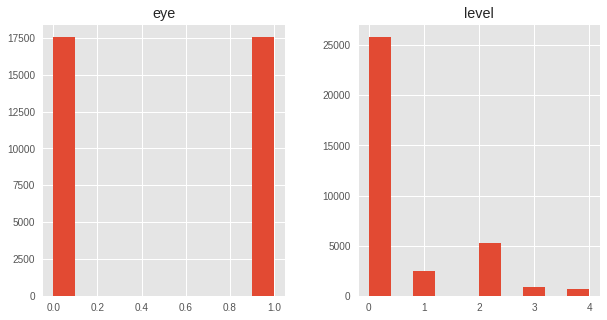

In [20]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [21]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


New Data Size: 750 Old Size: 27176


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb7e32d320>,
      dtype=object)

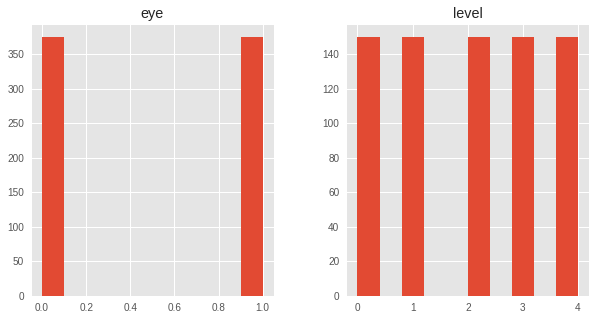

In [22]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [0]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [0]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

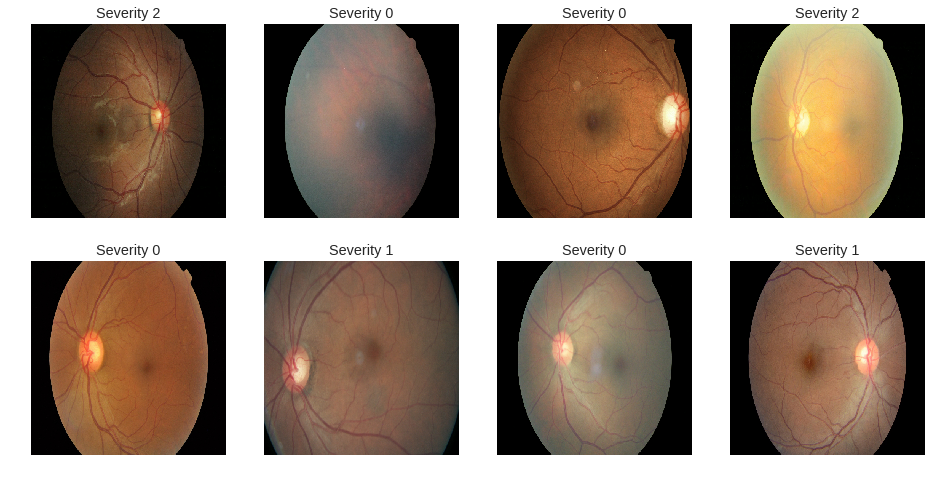

In [26]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

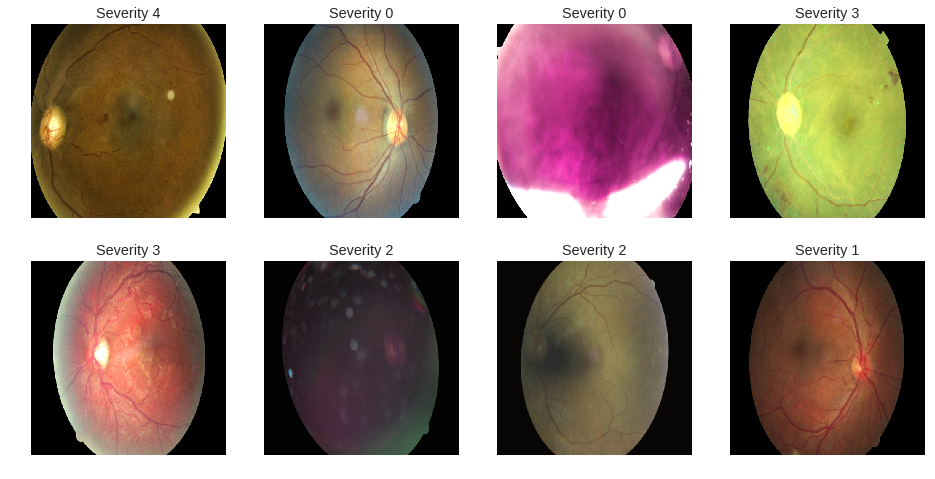

In [45]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [46]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

87916544/87910968 [==============================] - 8s 0us/step


In [47]:
# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [48]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [1]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

NameError: ignored

In [0]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [0]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

In [0]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [0]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

In [0]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

In [0]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [0]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_test_images.zip"):
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_detailed_class_info.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_sample_submission.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_train_labels.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_test_images.zip -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_train_images.zip -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f GCP Credits Request Link - RSNA.txt -p "/content/Pneumonia-Detection/"


  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 38.7MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 23.7MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 44.8MB/s]
 96% 361M/377M [00:03<00:00, 57.5MB/s]
100% 377M/377M [00:04<00:00, 96.4MB/s]
100% 3.28G/3.29G [00:38<00:00, 92.0MB/s]
100% 3.29G/3.29G [00:38<00:00, 92.6MB/s]
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: Request Link - RSNA.txt


In [6]:
!pip install pydicom

    100% |████████████████████████████████| 7.0MB 6.5MB/s 


In [0]:
if not os.path.isdir("/content/Pneumonia-Detection/train"):
  !mkdir "/content/Pneumonia-Detection/train"
  !unzip "/content/Pneumonia-Detection/stage_2_train_images.zip" -d "/content/Pneumonia-Detection/train"


In [0]:
if not os.path.isdir("/content/Pneumonia-Detection/test"):
  !mkdir "/content/Pneumonia-Detection/test"
  !unzip "/content/Pneumonia-Detection/stage_2_test_images.zip" -d "/content/Pneumonia-Detection/test"


In [0]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_detailed_class_info.csv"):
  !unzip "/content/Pneumonia-Detection/stage_2_detailed_class_info.csv.zip" -d "/content/Pneumonia-Detection"


Archive:  /content/Pneumonia-Detection/stage_2_detailed_class_info.csv.zip
  inflating: /content/Pneumonia-Detection/stage_2_detailed_class_info.csv  


In [0]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_train_labels.csv"):
  !unzip "/content/Pneumonia-Detection/stage_2_train_labels.csv.zip" -d "/content/Pneumonia-Detection"


Archive:  /content/Pneumonia-Detection/stage_2_train_labels.csv.zip
  inflating: /content/Pneumonia-Detection/stage_2_train_labels.csv  


In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
df_train_labels = pd.read_csv('/content/Pneumonia-Detection/stage_2_train_labels.csv')

In [0]:
print(df_train_labels.shape)
print(df_train_labels.columns)
print(df_train_labels.head())

(30227, 6)
Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [0]:
df_train = df_train_labels.drop_duplicates('patientId')

In [0]:
x = df_train_labels[df_train_labels['patientId']=='cb4de6ed-efda-429e-941e-650cf9f6e33d']

In [0]:
print(x)

                                  patientId   x   y  width  height  Target
22488  cb4de6ed-efda-429e-941e-650cf9f6e33d NaN NaN    NaN     NaN       0


In [0]:
print(os.path.isfile('/content/Pneumonia-Detection/train/'+'cb4de6ed-efda-429e-941e-650cf9f6e33d.dcm'))

True


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/Pneumonia-Detection/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        #print(filename)
        if os.path.isfile('/content/Pneumonia-Detection/train/'+filename+'.dcm'):
          #print("file is present ", filename)
          location = rows[1:5]
          pneumonia = rows[5]
          # if row contains pneumonia add label to dictionary
          # which contains a list of pneumonia locations per filename
          if pneumonia == '1':
              # convert string to float to int
              location = [int(float(i)) for i in location]
              # save pneumonia location in dictionary
              if filename in pneumonia_locations:
                  pneumonia_locations[filename].append(location)
              else:
                  pneumonia_locations[filename] = [location]
        else:
          print("file not present ", filename)

In [0]:
print(len(filenames))

NameError: ignored

In [0]:
print(len(pneumonia_locations))

6012


In [0]:
# load and shuffle filenames
folder = '/content/Pneumonia-Detection/train'
filenames = os.listdir(folder)
random.shuffle(filenames)
print(len(filenames))

26684


In [0]:
print(len(filenames))

26684


In [0]:
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


Total train images: 26684
Images with pneumonia: 6012


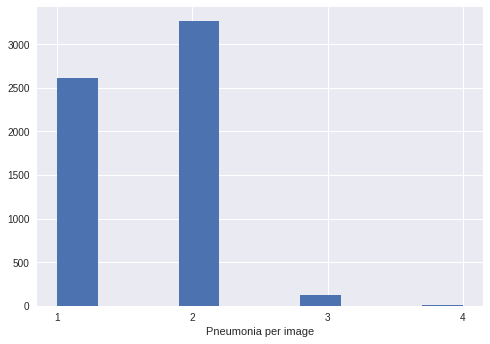

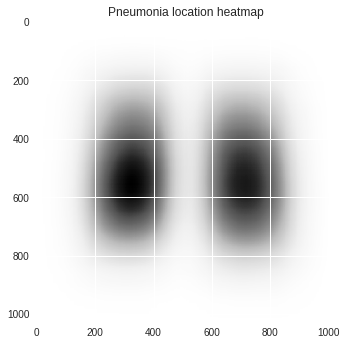

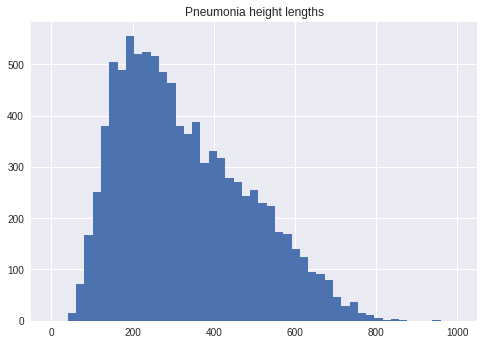

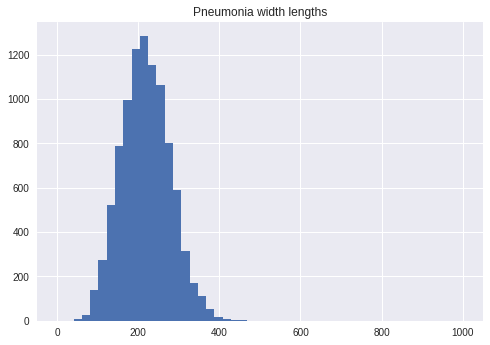

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
os.path.isfile('/content/train/cb4de6ed-efda-429e-941e-650cf9f6e33d.dcm')

False

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 2
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/Pneumonia-Detection/train'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=2, workers=4, use_multiprocessing=True)

Epoch 1/2
753/753 [==============================] - 938s 1s/step - loss: 15.3894 - acc: 0.9620 - mean_iou: 0.6034 - val_loss: 15.5805 - val_acc: 0.9607 - val_mean_iou: 0.5831
Epoch 2/2
753/753 [==============================] - 938s 1s/step - loss: 14.0324 - acc: 0.9683 - mean_iou: 0.6783 - val_loss: 14.3154 - val_acc: 0.9638 - val_mean_iou: 0.6136


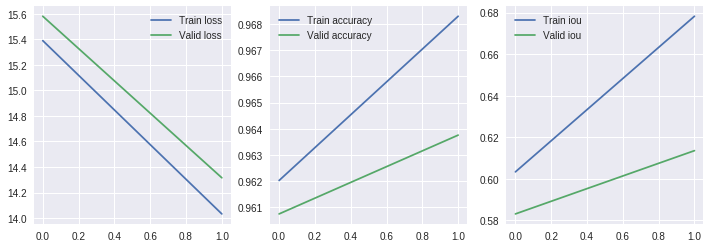

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

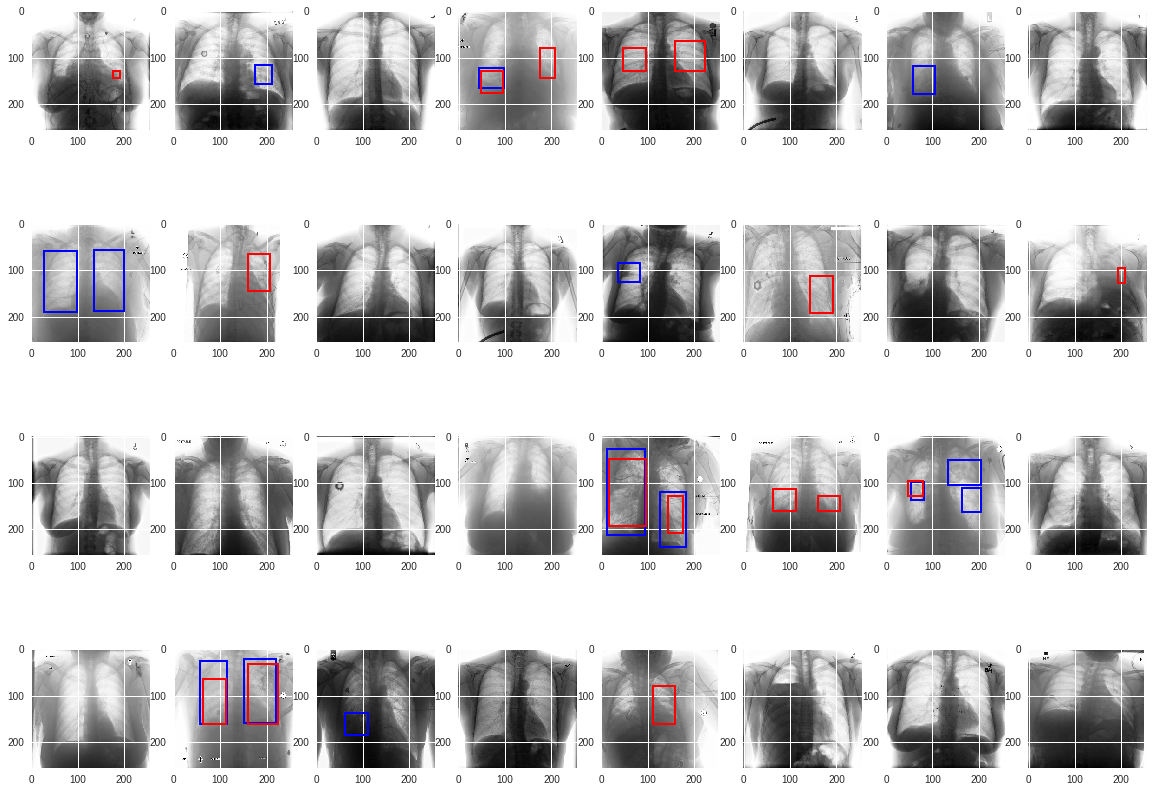

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [0]:
# load and shuffle filenames
folder = '/content/Pneumonia-Detection/test'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
